In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import PIL
import pathlib

print(tf.__version__)


2.8.0


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# 1. Data

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
data_dir

WindowsPath('C:/Users/Jin/.keras/datasets/flower_photos')

In [5]:
imageCount = len(list(data_dir.glob('*/*.jpg')))
print(imageCount)

3670


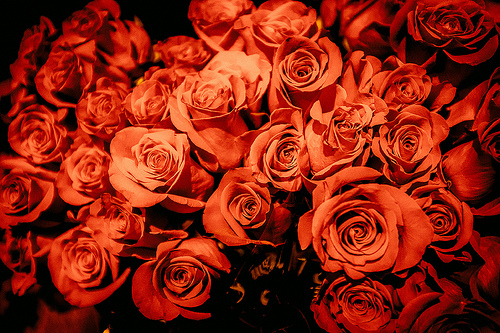

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[2]))

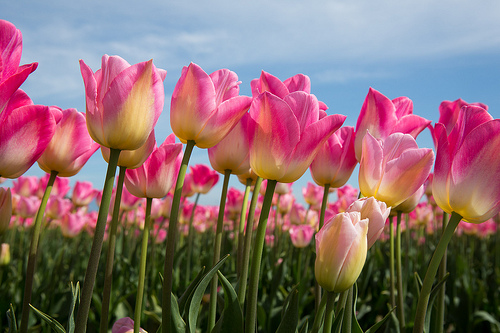

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[3]))

# 2. Dataset

In [8]:
batchSize = 32 
imgHeight = 180
imgWidth = 180

numClasses = 5
epochs = 10

In [9]:
trainDataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=0,
    image_size=(imgHeight, imgWidth),
    batch_size = batchSize
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
validationDataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=0,
    image_size=(imgHeight, imgWidth),
    batch_size = batchSize
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
class_names = trainDataset.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# 3. Visualization

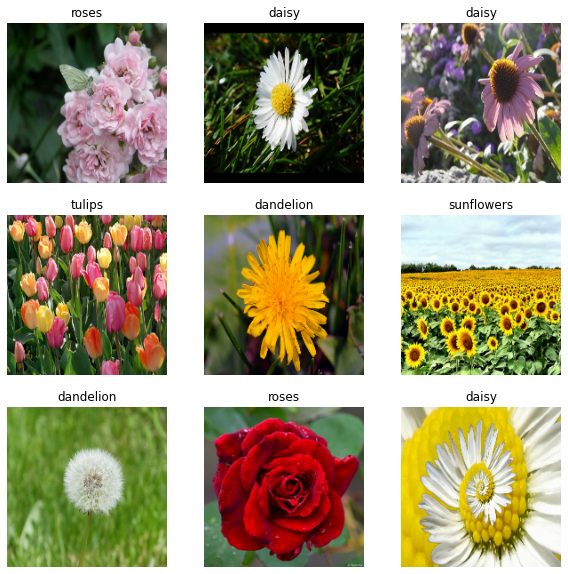

In [12]:
plt.figure(figsize=(10,10))
for images, labels in trainDataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
for imageBatch, labelsBatch in trainDataset:
  print(imageBatch.shape)
  print(labelsBatch.shape)
  break

(32, 180, 180, 3)
(32,)


In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

trainDataset = trainDataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validationDataset = validationDataset.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
nomalizationLayer = keras.layers.experimental.preprocessing.Rescaling(1./255)

In [16]:
nomalizedDataset = trainDataset.map(lambda x, y: (nomalizationLayer(x), y))
imageBatch, labelsBatch = next(iter(nomalizedDataset))
firstImage = imageBatch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(firstImage), np.max(firstImage))

0.0066087535 1.0


# 

In [17]:
model = keras.Sequential([
    keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(imgHeight, imgWidth, 3)),
    keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(numClasses)
])

In [18]:
model.compile(optimizer ='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [20]:
history = model.fit(trainDataset, 
                    validation_data=validationDataset,
                    epochs=epochs)

Epoch 1/10
92/92 [==============================] - 7s 36ms/step - loss: 1.3046 - accuracy: 0.4363 - val_loss: 1.0591 - val_accuracy: 0.5790
Epoch 2/10
92/92 [==============================] - 2s 27ms/step - loss: 0.9697 - accuracy: 0.6301 - val_loss: 0.9687 - val_accuracy: 0.6144
Epoch 3/10
92/92 [==============================] - 2s 27ms/step - loss: 0.7440 - accuracy: 0.7166 - val_loss: 0.9592 - val_accuracy: 0.6390
Epoch 4/10
92/92 [==============================] - 2s 27ms/step - loss: 0.5234 - accuracy: 0.8038 - val_loss: 1.0078 - val_accuracy: 0.6649
Epoch 5/10
92/92 [==============================] - 3s 27ms/step - loss: 0.3227 - accuracy: 0.8883 - val_loss: 1.0737 - val_accuracy: 0.6567
Epoch 6/10
92/92 [==============================] - 2s 27ms/step - loss: 0.1679 - accuracy: 0.9441 - val_loss: 1.3292 - val_accuracy: 0.6444
Epoch 7/10
92/92 [==============================] - 3s 28ms/step - loss: 0.1013 - accuracy: 0.9707 - val_loss: 1.3218 - val_accuracy: 0.6649
Epoch 8/10
92

In [24]:
def PlotGraphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

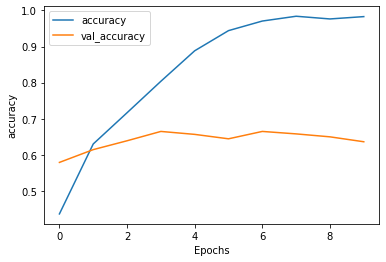

In [25]:
PlotGraphs(history, 'accuracy')

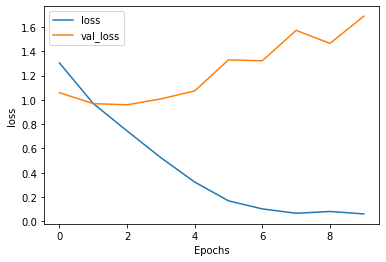

In [26]:
PlotGraphs(history, 'loss')

# 5. Data Augmentation

In [28]:
dataAgumentation = keras.Sequential([
    # Data Agumentation
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(imgHeight, imgWidth, 3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

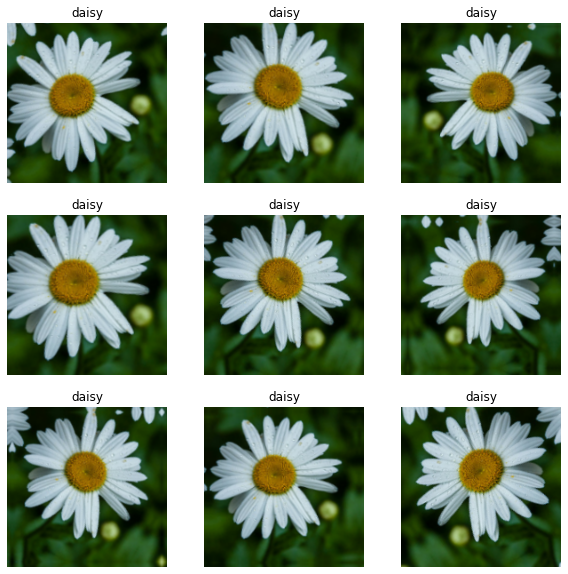

In [32]:
plt.figure(figsize=(10,10))
for images, labels in trainDataset.take(1):
    for i in range(9):
        argumentatedImage = dataAgumentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(argumentatedImage[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

In [49]:
model = keras.Sequential([
    dataAgumentation,
    keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(imgHeight, imgWidth, 3)),
    keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(numClasses)
])

In [50]:
model.compile(optimizer ='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [52]:
history = model.fit(trainDataset, 
                    validation_data=validationDataset,
                    epochs=15)

Epoch 1/15
92/92 [==============================] - 4s 32ms/step - loss: 1.3060 - accuracy: 0.4438 - val_loss: 1.1141 - val_accuracy: 0.5668
Epoch 2/15
92/92 [==============================] - 3s 30ms/step - loss: 1.0228 - accuracy: 0.6018 - val_loss: 1.0406 - val_accuracy: 0.5981
Epoch 3/15
92/92 [==============================] - 3s 31ms/step - loss: 0.9200 - accuracy: 0.6396 - val_loss: 1.0008 - val_accuracy: 0.6417
Epoch 4/15
92/92 [==============================] - 3s 31ms/step - loss: 0.8579 - accuracy: 0.6631 - val_loss: 0.9823 - val_accuracy: 0.6567
Epoch 5/15
92/92 [==============================] - 3s 31ms/step - loss: 0.8012 - accuracy: 0.6890 - val_loss: 0.9830 - val_accuracy: 0.6267
Epoch 6/15
92/92 [==============================] - 3s 31ms/step - loss: 0.7806 - accuracy: 0.7037 - val_loss: 0.8151 - val_accuracy: 0.6975
Epoch 7/15
92/92 [==============================] - 3s 31ms/step - loss: 0.7124 - accuracy: 0.7204 - val_loss: 0.9618 - val_accuracy: 0.6580
Epoch 8/15
92

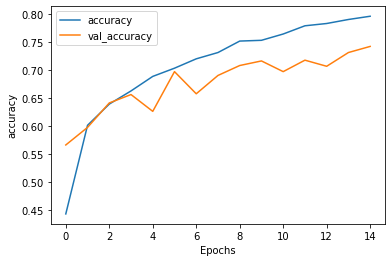

In [53]:
PlotGraphs(history, 'accuracy')

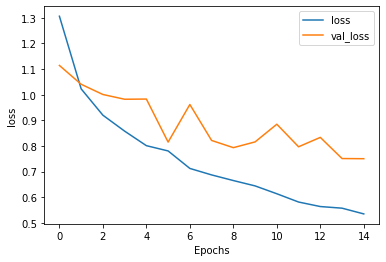

In [54]:
PlotGraphs(history, 'loss')